In [31]:
%reload_ext autoreload
%autoreload 1
import torch 
from matplotlib import pyplot
import sys
import numpy as np
sys.path.append('..')
from torch import nn 
from torch.nn import functional as F
from torch import optim
from utils.loader import load
from utils.loader import PairSetMNIST
import torch.utils.data as dt
from torch.utils.data import Dataset, DataLoader
from utils.plot import learning_curve
from utils.metrics import accuracy, compute_nb_errors

In [32]:
class LeNet_aux_sequential(nn.Module):
    
    """    
    Weight sharing + Auxiliary loss
    
    """
    def __init__(self):
        super(LeNet_aux_sequential, self).__init__()
        # convolutional weights for digit reocgnition shared for each image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        
        # weights for binary classification 
        self.fc3 = nn.Linear(20, 60)
        self.fc4 = nn.Linear(60, 90)
        self.fc5 = nn.Linear(90, 2)
        
    def forward(self, input_):    
        
        # split the 2-channel input into two 14*14 images
        x = input_[:, 0, :, :].view(-1, 1, 14, 14)
        y = input_[:, 1, :, :].view(-1, 1, 14, 14)
        
        # forward pass for the first image 
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        
        # forward pass for the second image 
        y = F.relu(F.max_pool2d(self.conv1(y), kernel_size=2, stride=2))
        y = F.relu(F.max_pool2d(self.conv2(y), kernel_size=2, stride=2))
        y = F.relu(self.fc1(y.view(-1, 256)))
        y = self.fc2(y)
        
        # concatenate layers  
        z = torch.cat([x, y], 1)
        
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = self.fc5(z)
        
        return x, y, z

In [41]:
#train for one epoch
def train_aux (model, train_data, validation_data, mini_batch_size=100, optimizer = optim.SGD,
                criterion = nn.CrossEntropyLoss(), n_epochs=50, eta=1e-1, lambda_l2 = 0, alpha=0.5, beta=0.5):
    
    """
    Train network with auxiliary loss + weight sharing
    
    """
    train_acc = []
    train_losses = []
    valid_acc = []
    valid_losses = []
    
    model.train()
    optimizer = optimizer(model.parameters(), lr = eta)
    
    for e in range(n_epochs):
        epoch_loss = 0
        train_loader = DataLoader(train_data, batch_size=mini_batch_size, shuffle=True)
        
        for i, data in enumerate(train_loader, 0):
            
            input_, target_, classes_ = data
            class_1, class_2, out = model(input_)
            aux_loss1 = criterion(class_1, classes_[:,0])
            aux_loss2 = criterion(class_2, classes_[:,1])
            out_loss  = criterion(out, target_)
            net_loss = (alpha * (out_loss) + beta * (aux_loss1 + aux_loss2) )
            epoch_loss += net_loss
            
            if lambda_l2 != 0:
                for p in model.parameters():
                    epoch_loss += lambda_l2 * p.pow(2).sum() # add an l2 penalty term to the loss 
            
            optimizer.zero_grad()
            net_loss.backward()
            optimizer.step()
            
        tr_loss, tr_acc = compute_metrics(model, train_data)
        val_loss, val_acc = compute_metrics(model, validation_data)
        
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        valid_acc.append(val_acc)
        valid_losses.append(val_loss)
            
        print('Train Epoch: {}  | Loss {:.6f}'.format(
                e, epoch_loss.item()))
        
    return train_losses, train_acc, valid_losses, valid_acc
        
# compute loss and accuracy
def compute_metrics(model, test_data, mini_batch_size=100, criterion = nn.CrossEntropyLoss()):
    
    """
    function to calculate prediction accuracy + loss of a cnn with auxiliary loss
    
    """
    test_loader = DataLoader(test_data, batch_size=mini_batch_size, shuffle=False)
    model.eval()
    test_loss = 0
    nb_errors = 0
    
    with torch.no_grad():
        
        for i, data in enumerate(test_loader, 0):
            input_, target_, classes_ = data
            _, _, output = model(input_) 
            batch_loss = criterion(output, target_)
            test_loss += batch_loss     
            nb_errors += compute_nb_errors(output, target_)
            
        acc = 100*(1 - (nb_errors/test_data.len) )
        test_loss = test_loss/test_data.len     # normalize loss
              
        return test_loss.item(), acc
    
def validate_model(net_type, mini_batch_size=100, optimizer = optim.SGD,
                 criterion = nn.CrossEntropyLoss(), n_epochs=40, eta=1e-1, 
                 lambda_l2 = 0, alpha=0.5, beta=0.5, plot=True): 

    """ Training / validation over n_epochs + testing a full test set"""
    
    train_data = PairSetMNIST(train=True)
    valid_data = PairSetMNIST(valid=True)
    test_data  = PairSetMNIST(test=True)
    
    model = net_type()
    train_losses, train_acc, valid_losses, valid_acc = train_aux(model, train_data, valid_data, mini_batch_size, optimizer, criterion, n_epochs, eta, lambda_l2, alpha, beta)
    
    if plot:
        
        learning_curve(train_losses, train_acc, valid_losses, valid_acc)

    test_loss, test_accuracy = compute_metrics(model, test_data)
    
    print('\nTest Set | Loss: {:.4f} | Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))
    
def evaluate_model(net_type, n_trials=10, mini_batch_size=100, optimizer = optim.SGD,
                 criterion = nn.CrossEntropyLoss(), n_epochs=40, eta=1e-1, 
                 lambda_l2 = 0, alpha=0.5, beta=0.5, plot=True): 
    
    """ 10 rounds of training / validation + testing metrics statistics  """
    
    train_results = torch.empty(n_trials, 4, n_epochs)
    test_losses = []
    test_accuracies = []
    
    for n in range(n_trials):
    
        train_data = PairSetMNIST(train=True)
        valid_data = PairSetMNIST(valid=True)
        test_data  = PairSetMNIST(test=True)
        
        model = net_type()

        train_losses, train_acc, valid_losses, valid_acc = train_aux(model, train_data, valid_data, mini_batch_size, optimizer, criterion, n_epochs, eta, lambda_l2, alpha, beta)
        train_results[n,] = torch.tensor([train_losses, train_acc, valid_losses, valid_acc])
        test_loss, test_acc = compute_metrics(model, test_data)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        if plot:
            
            learning_curve(train_losses, train_acc, valid_losses, valid_acc)
            
            
        
        print('\nTrial {:d} | Test Loss: {:.4f} | Test Accuracy: {:.2f}%\n'.format(n, test_loss, test_acc))
        
    return train_results, test_losses, test_accuracies
        

Train Epoch: 0  | Loss 20.971785
Train Epoch: 1  | Loss 20.422434
Train Epoch: 2  | Loss 19.547186
Train Epoch: 3  | Loss 17.638077
Train Epoch: 4  | Loss 15.317629
Train Epoch: 5  | Loss 12.984420
Train Epoch: 6  | Loss 10.930157
Train Epoch: 7  | Loss 9.687677
Train Epoch: 8  | Loss 7.059308
Train Epoch: 9  | Loss 11.760258
Train Epoch: 10  | Loss 7.298214
Train Epoch: 11  | Loss 5.724892
Train Epoch: 12  | Loss 4.854855
Train Epoch: 13  | Loss 4.250319
Train Epoch: 14  | Loss 3.443350
Train Epoch: 15  | Loss 5.304898
Train Epoch: 16  | Loss 3.120407
Train Epoch: 17  | Loss 2.738106
Train Epoch: 18  | Loss 2.689025
Train Epoch: 19  | Loss 2.489798
Train Epoch: 20  | Loss 2.305049
Train Epoch: 21  | Loss 2.132033
Train Epoch: 22  | Loss 1.870491
Train Epoch: 23  | Loss 1.951627
Train Epoch: 24  | Loss 1.630354
Train Epoch: 25  | Loss 1.569680
Train Epoch: 26  | Loss 1.432036
Train Epoch: 27  | Loss 1.736249
Train Epoch: 28  | Loss 1.255292
Train Epoch: 29  | Loss 1.279088
Train Epoch:

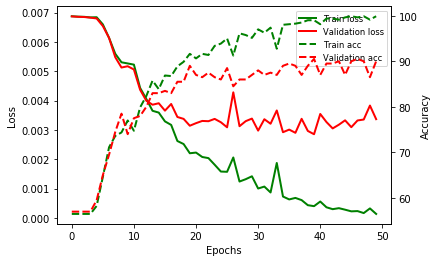


Trial 0 | Test Loss: 0.1976 | Test Accuracy: 90.50%

Train Epoch: 0  | Loss 20.894402
Train Epoch: 1  | Loss 19.812269
Train Epoch: 2  | Loss 17.710049
Train Epoch: 3  | Loss 15.769932
Train Epoch: 4  | Loss 12.777561
Train Epoch: 5  | Loss 10.287107
Train Epoch: 6  | Loss 9.252111
Train Epoch: 7  | Loss 7.305320
Train Epoch: 8  | Loss 9.111810
Train Epoch: 9  | Loss 5.649776
Train Epoch: 10  | Loss 4.792953
Train Epoch: 11  | Loss 4.605149
Train Epoch: 12  | Loss 4.040256
Train Epoch: 13  | Loss 3.383351
Train Epoch: 14  | Loss 2.991879
Train Epoch: 15  | Loss 2.752668
Train Epoch: 16  | Loss 3.793354
Train Epoch: 17  | Loss 2.549023
Train Epoch: 18  | Loss 2.296947
Train Epoch: 19  | Loss 2.731427
Train Epoch: 20  | Loss 1.985598
Train Epoch: 21  | Loss 1.761042
Train Epoch: 22  | Loss 2.002808
Train Epoch: 23  | Loss 1.582138
Train Epoch: 24  | Loss 1.599674
Train Epoch: 25  | Loss 1.413967
Train Epoch: 26  | Loss 1.452589
Train Epoch: 27  | Loss 1.270635
Train Epoch: 28  | Loss 1.

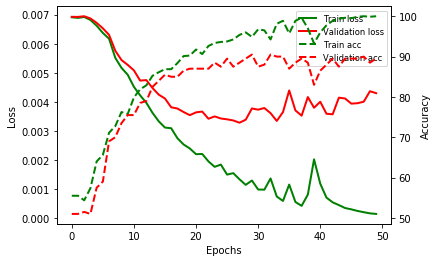


Trial 1 | Test Loss: 0.1715 | Test Accuracy: 91.00%

Train Epoch: 0  | Loss 20.809933
Train Epoch: 1  | Loss 19.526594
Train Epoch: 2  | Loss 17.280521
Train Epoch: 3  | Loss 15.194840
Train Epoch: 4  | Loss 11.690058
Train Epoch: 5  | Loss 11.490879
Train Epoch: 6  | Loss 9.035343
Train Epoch: 7  | Loss 7.946473
Train Epoch: 8  | Loss 5.723578
Train Epoch: 9  | Loss 5.469669
Train Epoch: 10  | Loss 5.390766
Train Epoch: 11  | Loss 4.050510
Train Epoch: 12  | Loss 3.814375
Train Epoch: 13  | Loss 4.413064
Train Epoch: 14  | Loss 3.373466
Train Epoch: 15  | Loss 2.995603
Train Epoch: 16  | Loss 2.941658
Train Epoch: 17  | Loss 2.978775
Train Epoch: 18  | Loss 2.591295
Train Epoch: 19  | Loss 2.278917
Train Epoch: 20  | Loss 3.251788
Train Epoch: 21  | Loss 2.130989
Train Epoch: 22  | Loss 1.929286
Train Epoch: 23  | Loss 1.877397
Train Epoch: 24  | Loss 1.766663
Train Epoch: 25  | Loss 1.589755
Train Epoch: 26  | Loss 1.456123
Train Epoch: 27  | Loss 1.462523
Train Epoch: 28  | Loss 1.

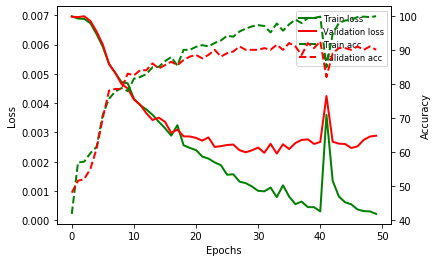


Trial 2 | Test Loss: 0.1592 | Test Accuracy: 90.80%

Train Epoch: 0  | Loss 20.910404
Train Epoch: 1  | Loss 19.786327
Train Epoch: 2  | Loss 17.990376
Train Epoch: 3  | Loss 15.950011
Train Epoch: 4  | Loss 14.923451
Train Epoch: 5  | Loss 11.619569
Train Epoch: 6  | Loss 11.928932
Train Epoch: 7  | Loss 9.208280
Train Epoch: 8  | Loss 7.518613
Train Epoch: 9  | Loss 6.649209
Train Epoch: 10  | Loss 6.335734
Train Epoch: 11  | Loss 5.047786
Train Epoch: 12  | Loss 5.013675
Train Epoch: 13  | Loss 4.180856
Train Epoch: 14  | Loss 4.323508
Train Epoch: 15  | Loss 4.427108
Train Epoch: 16  | Loss 3.385961
Train Epoch: 17  | Loss 3.457959
Train Epoch: 18  | Loss 2.798095
Train Epoch: 19  | Loss 2.467556
Train Epoch: 20  | Loss 2.795424
Train Epoch: 21  | Loss 2.396482
Train Epoch: 22  | Loss 2.017566
Train Epoch: 23  | Loss 1.896610
Train Epoch: 24  | Loss 1.939345
Train Epoch: 25  | Loss 1.724716
Train Epoch: 26  | Loss 1.653729
Train Epoch: 27  | Loss 1.501597
Train Epoch: 28  | Loss 1

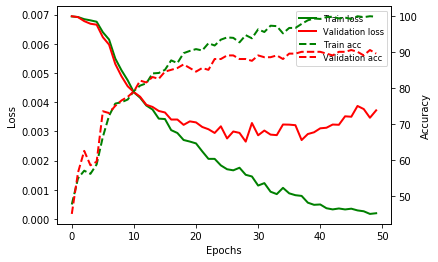


Trial 3 | Test Loss: 0.2721 | Test Accuracy: 87.90%

Train Epoch: 0  | Loss 20.877386
Train Epoch: 1  | Loss 19.970846
Train Epoch: 2  | Loss 18.132862
Train Epoch: 3  | Loss 16.243479
Train Epoch: 4  | Loss 13.245648
Train Epoch: 5  | Loss 10.703488
Train Epoch: 6  | Loss 10.252701
Train Epoch: 7  | Loss 8.671544
Train Epoch: 8  | Loss 6.873945
Train Epoch: 9  | Loss 4.964076
Train Epoch: 10  | Loss 7.713367
Train Epoch: 11  | Loss 4.211687
Train Epoch: 12  | Loss 3.941845
Train Epoch: 13  | Loss 3.476492
Train Epoch: 14  | Loss 3.009107
Train Epoch: 15  | Loss 2.695000
Train Epoch: 16  | Loss 4.524040
Train Epoch: 17  | Loss 3.249525
Train Epoch: 18  | Loss 2.259514
Train Epoch: 19  | Loss 2.314333
Train Epoch: 20  | Loss 1.994886
Train Epoch: 21  | Loss 1.870469
Train Epoch: 22  | Loss 1.701221
Train Epoch: 23  | Loss 1.621137
Train Epoch: 24  | Loss 1.564307
Train Epoch: 25  | Loss 1.657085
Train Epoch: 26  | Loss 1.630279
Train Epoch: 27  | Loss 1.202093
Train Epoch: 28  | Loss 1

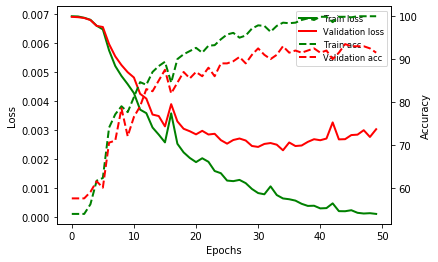


Trial 4 | Test Loss: 0.2668 | Test Accuracy: 89.00%

Train Epoch: 0  | Loss 20.828062
Train Epoch: 1  | Loss 19.640766
Train Epoch: 2  | Loss 17.410437
Train Epoch: 3  | Loss 15.380754
Train Epoch: 4  | Loss 12.306853
Train Epoch: 5  | Loss 9.740554
Train Epoch: 6  | Loss 8.744954
Train Epoch: 7  | Loss 7.872636
Train Epoch: 8  | Loss 6.854825
Train Epoch: 9  | Loss 5.624106
Train Epoch: 10  | Loss 4.531535
Train Epoch: 11  | Loss 4.393548
Train Epoch: 12  | Loss 3.763120
Train Epoch: 13  | Loss 3.628017
Train Epoch: 14  | Loss 3.602328
Train Epoch: 15  | Loss 3.475266
Train Epoch: 16  | Loss 2.893234
Train Epoch: 17  | Loss 2.518070
Train Epoch: 18  | Loss 2.398051
Train Epoch: 19  | Loss 2.175923
Train Epoch: 20  | Loss 3.175853
Train Epoch: 21  | Loss 3.266634
Train Epoch: 22  | Loss 1.942901
Train Epoch: 23  | Loss 1.733469
Train Epoch: 24  | Loss 1.721246
Train Epoch: 25  | Loss 1.488956
Train Epoch: 26  | Loss 1.385685
Train Epoch: 27  | Loss 1.462551
Train Epoch: 28  | Loss 1.2

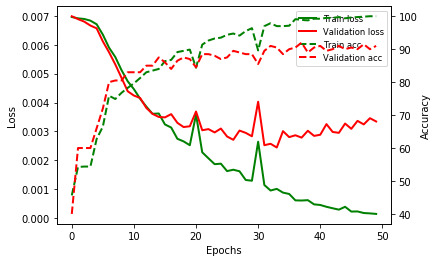


Trial 5 | Test Loss: 0.1493 | Test Accuracy: 91.50%

Train Epoch: 0  | Loss 20.895151
Train Epoch: 1  | Loss 20.196438
Train Epoch: 2  | Loss 18.882467
Train Epoch: 3  | Loss 16.448681
Train Epoch: 4  | Loss 13.753748
Train Epoch: 5  | Loss 13.498533
Train Epoch: 6  | Loss 9.925581
Train Epoch: 7  | Loss 9.121231
Train Epoch: 8  | Loss 7.424867
Train Epoch: 9  | Loss 6.678911
Train Epoch: 10  | Loss 5.558290
Train Epoch: 11  | Loss 6.116664
Train Epoch: 12  | Loss 4.526194
Train Epoch: 13  | Loss 4.607135
Train Epoch: 14  | Loss 4.093435
Train Epoch: 15  | Loss 3.944573
Train Epoch: 16  | Loss 3.384917
Train Epoch: 17  | Loss 4.265611
Train Epoch: 18  | Loss 3.068029
Train Epoch: 19  | Loss 3.069603
Train Epoch: 20  | Loss 2.735955
Train Epoch: 21  | Loss 2.544384
Train Epoch: 22  | Loss 3.074191
Train Epoch: 23  | Loss 2.201396
Train Epoch: 24  | Loss 2.122617
Train Epoch: 25  | Loss 1.969807
Train Epoch: 26  | Loss 1.871710
Train Epoch: 27  | Loss 1.885421
Train Epoch: 28  | Loss 1.

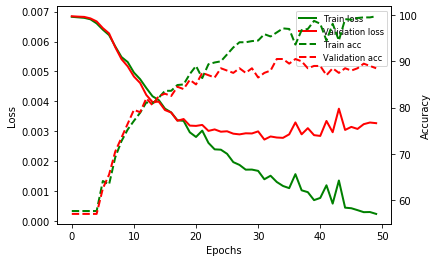


Trial 6 | Test Loss: 0.1487 | Test Accuracy: 90.00%

Train Epoch: 0  | Loss 20.692238
Train Epoch: 1  | Loss 19.425598
Train Epoch: 2  | Loss 16.781113
Train Epoch: 3  | Loss 14.734566
Train Epoch: 4  | Loss 13.379847
Train Epoch: 5  | Loss 9.508156
Train Epoch: 6  | Loss 8.055703
Train Epoch: 7  | Loss 7.462088
Train Epoch: 8  | Loss 6.251818
Train Epoch: 9  | Loss 5.316410
Train Epoch: 10  | Loss 5.552466
Train Epoch: 11  | Loss 4.368405
Train Epoch: 12  | Loss 3.850422
Train Epoch: 13  | Loss 3.668333
Train Epoch: 14  | Loss 3.319194
Train Epoch: 15  | Loss 3.191231
Train Epoch: 16  | Loss 2.881296
Train Epoch: 17  | Loss 2.589702
Train Epoch: 18  | Loss 2.288050
Train Epoch: 19  | Loss 2.222713
Train Epoch: 20  | Loss 2.199827
Train Epoch: 21  | Loss 2.125943
Train Epoch: 22  | Loss 2.068234
Train Epoch: 23  | Loss 1.627551
Train Epoch: 24  | Loss 1.558945
Train Epoch: 25  | Loss 1.571668
Train Epoch: 26  | Loss 1.608966
Train Epoch: 27  | Loss 1.450897
Train Epoch: 28  | Loss 1.1

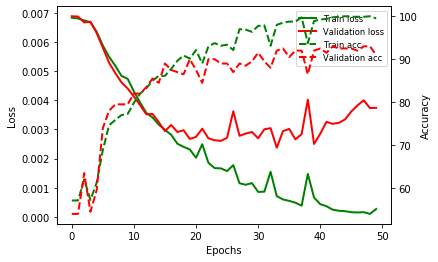


Trial 7 | Test Loss: 0.2595 | Test Accuracy: 89.60%

Train Epoch: 0  | Loss 20.823719
Train Epoch: 1  | Loss 19.402821
Train Epoch: 2  | Loss 16.940639
Train Epoch: 3  | Loss 14.692492
Train Epoch: 4  | Loss 13.772388
Train Epoch: 5  | Loss 9.980721
Train Epoch: 6  | Loss 8.439536
Train Epoch: 7  | Loss 6.639075
Train Epoch: 8  | Loss 6.977755
Train Epoch: 9  | Loss 4.993165
Train Epoch: 10  | Loss 5.100273
Train Epoch: 11  | Loss 3.909128
Train Epoch: 12  | Loss 3.304155
Train Epoch: 13  | Loss 3.847749
Train Epoch: 14  | Loss 2.752967
Train Epoch: 15  | Loss 2.604995
Train Epoch: 16  | Loss 2.344530
Train Epoch: 17  | Loss 3.016829
Train Epoch: 18  | Loss 2.119351
Train Epoch: 19  | Loss 1.869750
Train Epoch: 20  | Loss 1.739552
Train Epoch: 21  | Loss 1.621809
Train Epoch: 22  | Loss 1.512650
Train Epoch: 23  | Loss 1.383839
Train Epoch: 24  | Loss 1.499276
Train Epoch: 25  | Loss 3.751693
Train Epoch: 26  | Loss 1.367319
Train Epoch: 27  | Loss 1.175651
Train Epoch: 28  | Loss 1.1

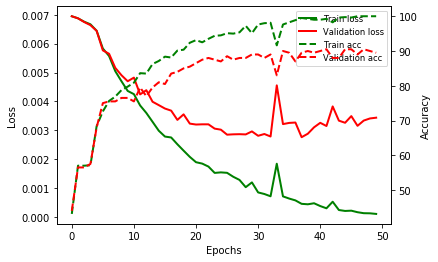


Trial 8 | Test Loss: 0.2194 | Test Accuracy: 90.00%

Train Epoch: 0  | Loss 20.986504
Train Epoch: 1  | Loss 20.226416
Train Epoch: 2  | Loss 18.920988
Train Epoch: 3  | Loss 17.223644
Train Epoch: 4  | Loss 14.593579
Train Epoch: 5  | Loss 13.242929
Train Epoch: 6  | Loss 10.440943
Train Epoch: 7  | Loss 9.053747
Train Epoch: 8  | Loss 7.837317
Train Epoch: 9  | Loss 7.199696
Train Epoch: 10  | Loss 5.573489
Train Epoch: 11  | Loss 5.040108
Train Epoch: 12  | Loss 5.228766
Train Epoch: 13  | Loss 4.811922
Train Epoch: 14  | Loss 4.374670
Train Epoch: 15  | Loss 3.712903
Train Epoch: 16  | Loss 3.198745
Train Epoch: 17  | Loss 3.102672
Train Epoch: 18  | Loss 3.021320
Train Epoch: 19  | Loss 2.759010
Train Epoch: 20  | Loss 2.343748
Train Epoch: 21  | Loss 2.295472
Train Epoch: 22  | Loss 2.078087
Train Epoch: 23  | Loss 1.950166
Train Epoch: 24  | Loss 1.809582
Train Epoch: 25  | Loss 1.684923
Train Epoch: 26  | Loss 1.706915
Train Epoch: 27  | Loss 1.735726
Train Epoch: 28  | Loss 1

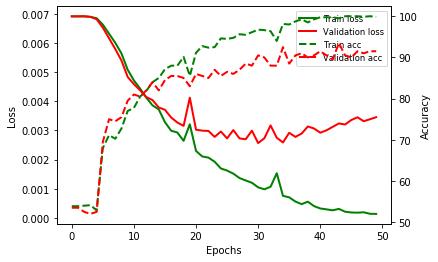


Trial 9 | Test Loss: 0.3323 | Test Accuracy: 87.60%



(tensor([[[6.8747e-03, 6.8612e-03, 6.8548e-03,  ..., 1.6755e-04,
           3.2611e-04, 1.3866e-04],
          [5.6500e+01, 5.6500e+01, 5.6500e+01,  ..., 9.9875e+01,
           9.9125e+01, 9.9875e+01],
          [6.8692e-03, 6.8555e-03, 6.8483e-03,  ..., 3.3553e-03,
           3.8318e-03, 3.3676e-03],
          [5.7000e+01, 5.7000e+01, 5.7000e+01,  ..., 9.0000e+01,
           8.6500e+01, 9.0000e+01]],
 
         [[6.9082e-03, 6.8881e-03, 6.9189e-03,  ..., 2.0638e-04,
           1.6619e-04, 1.4703e-04],
          [5.5500e+01, 5.5500e+01, 5.4375e+01,  ..., 1.0000e+02,
           9.9875e+01, 1.0000e+02],
          [6.9246e-03, 6.9220e-03, 6.9445e-03,  ..., 4.0054e-03,
           4.3658e-03, 4.2995e-03],
          [5.1000e+01, 5.1000e+01, 5.1500e+01,  ..., 9.0000e+01,
           8.8500e+01, 8.9500e+01]],
 
         [[6.9640e-03, 6.8885e-03, 6.8746e-03,  ..., 3.1253e-04,
           3.0322e-04, 2.1705e-04],
          [4.1750e+01, 5.6875e+01, 5.7125e+01,  ..., 9.9750e+01,
           9.9625e+0

In [42]:
# evaluate models 

evaluate_model(LeNet_aux_sequential, n_epochs=50)

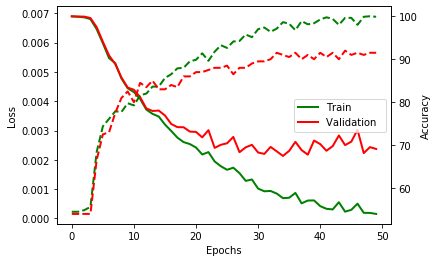

In [12]:
learning_curve(train_losses, train_acc, valid_losses, valid_acc)

In [5]:
x = PairSetMNIST(train=True)

In [6]:
x

In [7]:
type(x)

utils.loader.PairSetMNIST

In [4]:
u = torch.empty(3, 4, 5)

In [5]:
u

tensor([[[ 0.0000e+00,  0.0000e+00,  4.8604e+12,  7.0205e-43,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.2961e+12,  7.0205e-43,  1.1210e-44,  0.0000e+00, -1.1671e-12],
         [ 4.5911e-41,  5.7397e-42,  0.0000e+00,  1.1210e-44,  0.0000e+00]],

        [[-1.1701e-12,  4.5911e-41,  2.8026e-45,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.8699e-40,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,         nan,         nan,  0.0000e+00],
         [ 0.0000e+00,  5.3266e-39,  7.8061e-39,  9.2755e-39,  1.0561e-38]],

        [[ 7.8980e-39,  1.0102e-38,  9.2755e-39,  1.0653e-38,  6.0612e-39],
         [ 1.0469e-38,  8.9082e-39,  1.0469e-38,  8.4490e-39,  1.0102e-38],
         [ 9.0919e-39,  1.0102e-38,  8.9082e-39,  8.4489e-39,  6.9796e-39],
         [ 1.0561e-38,  1.0286e-38,  9.2756e-39,  1.0286e-38,  1.0653e-38]]])

In [26]:
s = [1, 2, 3, 4, 4] 
u[0,] = torch.tensor([s, s, s, s])

In [23]:
type(u)

torch.Tensor

In [27]:
u

tensor([[[ 1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,  4.0000e+00],
         [ 1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,  4.0000e+00],
         [ 1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,  4.0000e+00],
         [ 1.0000e+00,  2.0000e+00,  3.0000e+00,  4.0000e+00,  4.0000e+00]],

        [[-1.1701e-12,  4.5911e-41,  2.8026e-45,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.8699e-40,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,         nan,         nan,  0.0000e+00],
         [ 0.0000e+00,  5.3266e-39,  7.8061e-39,  9.2755e-39,  1.0561e-38]],

        [[ 7.8980e-39,  1.0102e-38,  9.2755e-39,  1.0653e-38,  6.0612e-39],
         [ 1.0469e-38,  8.9082e-39,  1.0469e-38,  8.4490e-39,  1.0102e-38],
         [ 9.0919e-39,  1.0102e-38,  8.9082e-39,  8.4489e-39,  6.9796e-39],
         [ 1.0561e-38,  1.0286e-38,  9.2756e-39,  1.0286e-38,  1.0653e-38]]])